In [6]:
!pip install tensorflow keras -q

# Time Series Forecasting with LSTM
Daily Climate Time Series Data (Kaggle)

Using official Train & Test datasets

## 1. Imports

In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


## 2. Load Train and Test Datasets

In [8]:

train_df = pd.read_csv("DailyDelhiClimateTrain.csv")
test_df  = pd.read_csv("DailyDelhiClimateTest.csv")

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

train_df.set_index('date', inplace=True)
test_df.set_index('date', inplace=True)

train_temp = train_df[['meantemp']]
test_temp  = test_df[['meantemp']]

train_temp.head(), test_temp.head()


(             meantemp
 date                 
 2013-01-01  10.000000
 2013-01-02   7.400000
 2013-01-03   7.166667
 2013-01-04   8.666667
 2013-01-05   6.000000,
              meantemp
 date                 
 2017-01-01  15.913043
 2017-01-02  18.500000
 2017-01-03  17.111111
 2017-01-04  18.700000
 2017-01-05  18.388889)

## 3. Visualize Training Data

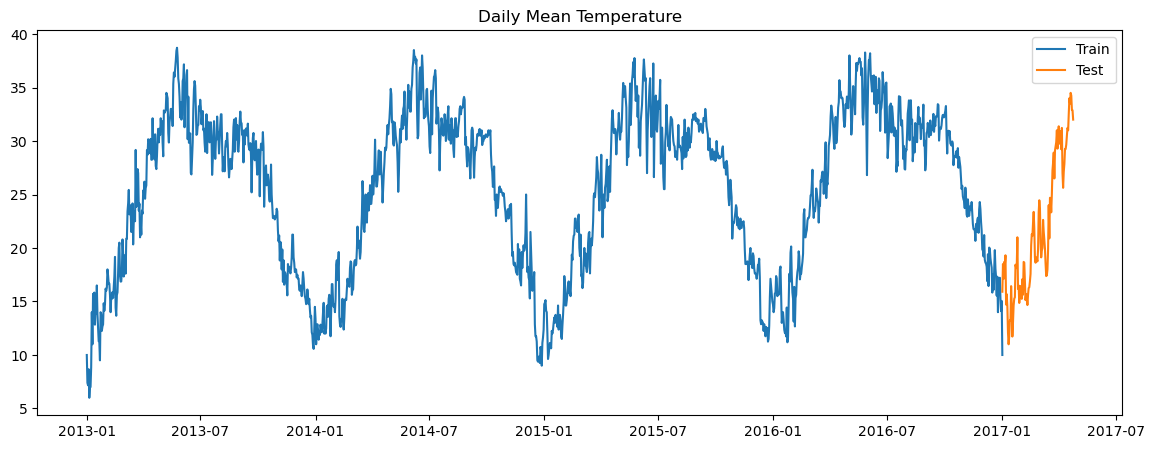

In [9]:

plt.figure(figsize=(14,5))
plt.plot(train_temp, label='Train')
plt.plot(test_temp, label='Test')
plt.title("Daily Mean Temperature")
plt.legend()
plt.show()


## 4. Decomposition

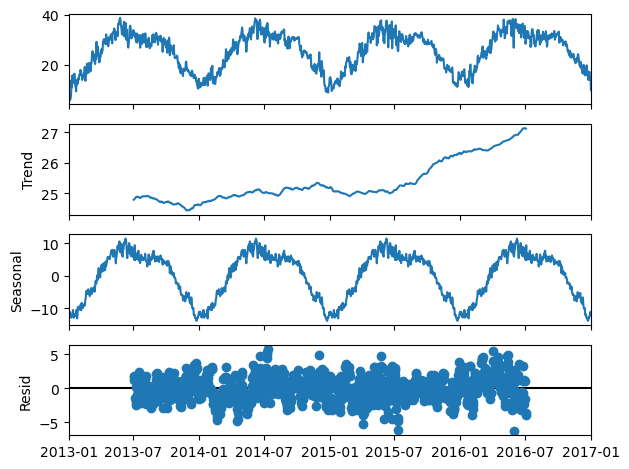

In [10]:

seasonal_decompose(train_temp, model='additive', period=365).plot()
plt.show()


## 5. ADF Stationarity Test

In [11]:

result = adfuller(train_temp['meantemp'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -2.021069055920669
p-value: 0.277412137230162


## 6. Scale Data

In [12]:

scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_temp)
test_scaled = scaler.transform(test_temp)


## 7. Create LSTM Sequences

In [13]:

def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

WINDOW_SIZE = 30

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test, y_test = create_sequences(
    np.concatenate((train_scaled[-WINDOW_SIZE:], test_scaled)), 
    WINDOW_SIZE
)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


## 8. Build LSTM Model

In [14]:

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(0.001), loss='mse')
model.summary()


c:\Users\landm\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

## 9. Train Model

In [15]:

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 168ms/step - loss: 0.0563 - val_loss: 0.0047
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0097 - val_loss: 0.0031
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0092 - val_loss: 0.0028
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0086 - val_loss: 0.0028
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0078 - val_loss: 0.0027
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0078 - val_loss: 0.0025
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0073 - val_loss: 0.0028
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0073 - val_loss: 0.0025
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0078 - val_loss: 0.0037
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0072 - val_loss: 0.0025
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0072 - val_loss: 0.0029
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0

## 10. Evaluate on Test Set

In [16]:

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)

print("RMSE:", rmse)
print("MAE:", mae)


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 
RMSE: 2.2912934002698604
MAE: 1.9492214039601863


## 11. Actual vs Predicted

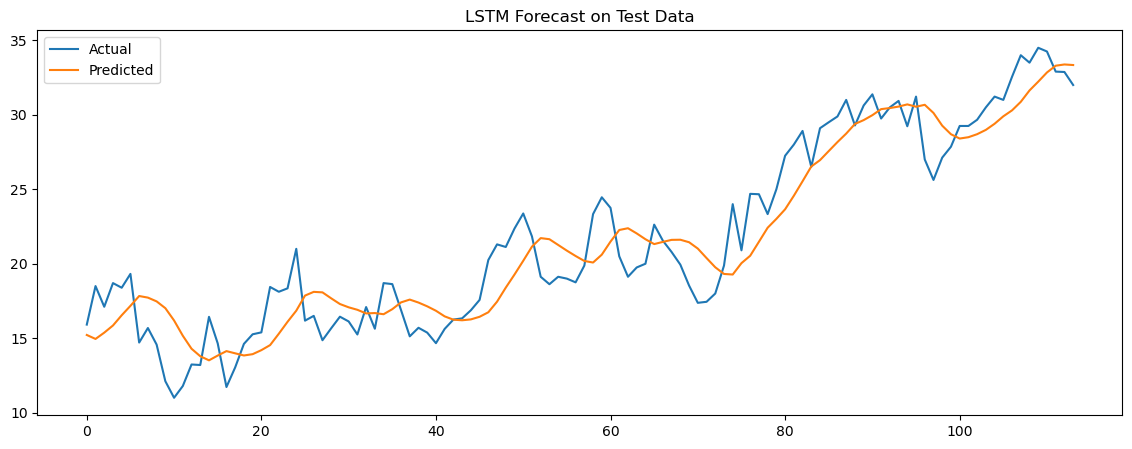

In [17]:

plt.figure(figsize=(14,5))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title("LSTM Forecast on Test Data")
plt.legend()
plt.show()


## 12. Conclusion


- Model successfully captures temporal dependencies  
- LSTM handles seasonal patterns effectively  
- Errors evaluated using RMSE and MAE  
- Limited by window size and univariate input  
